In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.stats.multitest as smm
import numpy as np
#from bioinfokit import analys, visuz
from matplotlib.patches import Circle
from matplotlib.patheffects import withStroke
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import matplotlib

color_palette = sns.color_palette("colorblind")

sns.set_theme(palette=color_palette, font="Arial", font_scale=1.0, style="white")

plt.style.use('../mpl_style_template/poster.mplstyle')

"""matplotlib.rcParams.update({'font.size': 8, 'axes.titlesize': 8, 'axes.labelsize': 8,
                           'xtick.labelsize': 8, 'ytick.labelsize': 8, 'legend.fontsize': 8,
                            'text.usetex': False, 'svg.fonttype': 'none',
                           'xtick.direction': 'out', 'ytick.direction': 'out',
                            'xtick.bottom': True, 'ytick.left': True,})"""

#matplotlib.rcParams.update({'axes.labelsize': 16,'xtick.labelsize': 16,})
import os


In [2]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 25)
#pd.set_option('display.max_colwidth', 300)
#pd.set_option('format.precision', 2)




In [3]:
#Load "targets_and_families from https://www.guidetopharmacology.org/download.jsp

targets_families=pd.read_csv("targets_and_families_220518.csv", header=1, \
                             usecols=['Type', \
                                      'Family id', \
                                      'Family name', \
                                      'Target id', \
                                      'Target name',\
                                      'Subunits', \
                                      'Target systematic name', \
                                      'Target abbreviated name', \
                                      'synonyms', \
                                      'MGI id',\
                                      'MGI symbol', \
                                      'MGI name',\
                                      'Mouse Ensembl Gene']) 

#drop rows where no Ensembl Gene is available
targets_families.dropna(subset=['Mouse Ensembl Gene'], inplace=True)
targets_families

,Type,Family id,Family name,Target id,Target name,Subunits,Target systematic name,Target abbreviated name,synonyms,MGI id,MGI symbol,MGI name,Mouse Ensembl Gene
0,gpcr,1,5-Hydroxytryptamine receptors,1,5-HT<sub>1A</sub> receptor,NaN,NaN,NaN,ADRBRL1|5-HT1A|ADRB2RL1|serotonin receptor 1A|...,MGI:96273,Htr1a,5-hydroxytryptamine (serotonin) receptor 1A,ENSMUSG00000021721
1,gpcr,1,5-Hydroxytryptamine receptors,2,5-HT<sub>1B</sub> receptor,NaN,NaN,NaN,5-HT1B|5-HT1DB|HTR1D2|5-HT1B serotonin recepto...,MGI:96274,Htr1b,5-hydroxytryptamine (serotonin) receptor 1B,ENSMUSG00000049511
2,gpcr,1,5-Hydroxytryptamine receptors,3,5-HT<sub>1D</sub> receptor,NaN,NaN,NaN,5-HT<sub>1D&alpha;</sub>|HTRL|5-HT1D|HT1DA|ser...,MGI:96276,Htr1d,5-hydroxytryptamine (serotonin) receptor 1D,ENSMUSG00000070687
4,gpcr,1,5-Hydroxytryptamine receptors,5,5-HT<sub>1F</sub> receptor,NaN,NaN,NaN,5-HT<sub>1E&beta;</sub>|5-HT<sub>6</sub>|5-HT1...,MGI:99842,Htr1f,5-hydroxytryptamine (serotonin) receptor 1F,ENSMUSG00000050783
5,gpcr,1,5-Hydroxytryptamine receptors,6,5-HT<sub>2A</sub> receptor,NaN,NaN,NaN,'D' receptor|5Ht-2|serotonin 5HT-2 receptor|se...,MGI:109521,Htr2a,5-hydroxytryptamine (serotonin) receptor 2A,ENSMUSG00000034997
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,other_protein,858,Tubulins,2641,tubulin beta 4B class IVb,NaN,NaN,NaN,"tubulin, beta 4B class IVb|tubulin|tubulin, be...",MGI:1915472,Tubb4b,"tubulin, beta 4B class IVB",ENSMUSG00000036752
3217,other_protein,904,Tumour-associated antigens,2959,glypican 3,NaN,NaN,NaN,NaN,MGI:104903,Gpc3,glypican 3,ENSMUSG00000055653
3219,other_protein,904,Tumour-associated antigens,3009,trophoblast glycoprotein,NaN,NaN,NaN,5T4|5T4-Ag|5T4 oncofetal antigen|Wnt-activated...,MGI:1341264,Tpbg,trophoblast glycoprotein,ENSMUSG00000035274
3220,other_protein,904,Tumour-associated antigens,2837,tumor associated calcium signal transducer 2,NaN,NaN,NaN,M1S1|EGP-1|TROP2|TROP-2|GA733-1|RS7 antigen|tu...,MGI:1861606,Tacstd2,tumor-associated calcium signal transducer 2,ENSMUSG00000051397


In [4]:
#unique family types
targets_families["Type"].unique()

array(['gpcr', 'nhr', 'vgic', 'lgic', 'other_ic', 'catalytic_receptor',
       'enzyme', 'transporter', 'other_protein'], dtype=object)

In [5]:
#number of unique genes 
#75 genes have more than one entry resulting in 79 duplicates
targets_families["Mouse Ensembl Gene"].nunique()

2830

In [9]:
#genes with more than one entry
ids = targets_families["Mouse Ensembl Gene"]
print(len(targets_families[ids.isin(ids[ids.duplicated()])].sort_values("Mouse Ensembl Gene")))
targets_families[ids.isin(ids[ids.duplicated()])].sort_values("Mouse Ensembl Gene")

75


,Type,Family id,Family name,Target id,Target name,Subunits,Target systematic name,Target abbreviated name,synonyms,MGI id,MGI symbol,MGI name,Mouse Ensembl Gene
1410,enzyme,766,Catecholamine turnover,1243,L-Tyrosine hydroxylase,NaN,NaN,NaN,Tyrosine 3-monooxygenase|The|tyrosine 3-hydrox...,MGI:98735,Th,tyrosine hydroxylase,ENSMUSG00000000214
1289,enzyme,249,Amino acid hydroxylases,1243,L-Tyrosine hydroxylase,NaN,NaN,NaN,Tyrosine 3-monooxygenase|The|tyrosine 3-hydrox...,MGI:98735,Th,tyrosine hydroxylase,ENSMUSG00000000214
1106,enzyme,840,1.-.-.- Oxidoreductases,2624,inosine monophosphate dehydrogenase 1,NaN,NaN,IMPDH1,LCA11|IMP (inosine 5'-monophosphate) dehydroge...,MGI:96567,Impdh1,inosine monophosphate dehydrogenase 1,ENSMUSG00000003500
1918,enzyme,920,Nucleoside synthesis and metabolism,2624,inosine monophosphate dehydrogenase 1,NaN,NaN,IMPDH1,LCA11|IMP (inosine 5'-monophosphate) dehydroge...,MGI:96567,Impdh1,inosine monophosphate dehydrogenase 1,ENSMUSG00000003500
3196,other_protein,1000,Sialic acid binding Ig like lectins,2601,CD33,NaN,NaN,SIGLEC3,SIGLEC3,MGI:99440,Cd33,CD33 antigen,ENSMUSG00000004609
3147,other_protein,949,Other immune checkpoint proteins,2601,CD33,NaN,NaN,SIGLEC3,SIGLEC3,MGI:99440,Cd33,CD33 antigen,ENSMUSG00000004609
2962,other_protein,852,CD molecules,2601,CD33,NaN,NaN,SIGLEC3,SIGLEC3,MGI:99440,Cd33,CD33 antigen,ENSMUSG00000004609
1688,enzyme,272,Leukotriene and lipoxin metabolism,1395,Leukotriene A<sub>4</sub> hydrolase,NaN,NaN,NaN,NaN,MGI:96836,Lta4h,leukotriene A4 hydrolase,ENSMUSG00000015889
1807,enzyme,737,M1: Aminopeptidase N,1395,Leukotriene A<sub>4</sub> hydrolase,NaN,NaN,NaN,NaN,MGI:96836,Lta4h,leukotriene A4 hydrolase,ENSMUSG00000015889
1609,enzyme,799,Hydrolases,1395,Leukotriene A<sub>4</sub> hydrolase,NaN,NaN,NaN,NaN,MGI:96836,Lta4h,leukotriene A4 hydrolase,ENSMUSG00000015889


In [10]:
# load results table from R DESeq analysis (gene-level, LFC shrinkage)
results_genes=pd.read_csv("shrink_Anno.csv")  
results_genes.rename(columns={"Unnamed: 0": "GENEID"}, inplace = True)

results_genes#.dropna(axis=0, subset=["SYMBOL"])
results_genes #all GENEIDs are unique

,GENEID,baseMean,log2FoldChange,lfcSE,pvalue,padj,GENENAME,SYMBOL,ENTREZID
0,ENSMUSG00000000001,6199.665736,0.290552,0.058169,4.072323e-08,0.000096,Gnai3,Gnai3,14679.0
1,ENSMUSG00000000003,0.000000,NaN,NaN,NaN,NaN,Pbsn,Pbsn,54192.0
2,ENSMUSG00000000028,135.410049,0.023191,0.069728,1.041882e-01,0.564404,Cdc45,Cdc45,12544.0
3,ENSMUSG00000000037,26.062083,-0.009071,0.065583,2.880739e-01,0.786633,Scml2,Scml2,107815.0
4,ENSMUSG00000000049,1.727977,0.003275,0.065297,1.904263e-01,NaN,Apoh,Apoh,11818.0
...,...,...,...,...,...,...,...,...,...
35677,ENSMUSG00000118670,2.452789,-0.002622,0.065113,5.924836e-01,NaN,NaN,NaN,NaN
35678,ENSMUSG00000118671,254.637367,-0.003083,0.062567,8.624442e-01,0.982947,EPPK1,EPPK1,NaN
35679,ENSMUSG00000118672,0.000000,NaN,NaN,NaN,NaN,Muc4,Muc4,140474.0
35680,ENSMUSG00001074846,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,68265.0


In [11]:
# merge with targets_family information
data = results_genes.merge(targets_families, how = "left", 
                           left_on='GENEID', 
                           right_on='Mouse Ensembl Gene', 
                           validate="one_to_many")

In [12]:
ids = data["GENEID"]
data[ids.isin(ids[ids.duplicated()])]# genes that have mor then one entry and their dupicates

,GENEID,baseMean,log2FoldChange,lfcSE,pvalue,padj,GENENAME,SYMBOL,ENTREZID,Type,Family id,Family name,Target id,Target name,Subunits,Target systematic name,Target abbreviated name,synonyms,MGI id,MGI symbol,MGI name,Mouse Ensembl Gene
35,ENSMUSG00000000214,3370.078812,0.019837,0.067303,0.233710,0.739511,Th,Th,21823.0,enzyme,249.0,Amino acid hydroxylases,1243.0,L-Tyrosine hydroxylase,NaN,NaN,NaN,Tyrosine 3-monooxygenase|The|tyrosine 3-hydrox...,MGI:98735,Th,tyrosine hydroxylase,ENSMUSG00000000214
36,ENSMUSG00000000214,3370.078812,0.019837,0.067303,0.233710,0.739511,Th,Th,21823.0,enzyme,766.0,Catecholamine turnover,1243.0,L-Tyrosine hydroxylase,NaN,NaN,NaN,Tyrosine 3-monooxygenase|The|tyrosine 3-hydrox...,MGI:98735,Th,tyrosine hydroxylase,ENSMUSG00000000214
595,ENSMUSG00000003500,573.917972,0.019989,0.064158,0.462087,0.871124,Impdh1,Impdh1,23917.0,enzyme,840.0,1.-.-.- Oxidoreductases,2624.0,inosine monophosphate dehydrogenase 1,NaN,NaN,IMPDH1,LCA11|IMP (inosine 5'-monophosphate) dehydroge...,MGI:96567,Impdh1,inosine monophosphate dehydrogenase 1,ENSMUSG00000003500
596,ENSMUSG00000003500,573.917972,0.019989,0.064158,0.462087,0.871124,Impdh1,Impdh1,23917.0,enzyme,920.0,Nucleoside synthesis and metabolism,2624.0,inosine monophosphate dehydrogenase 1,NaN,NaN,IMPDH1,LCA11|IMP (inosine 5'-monophosphate) dehydroge...,MGI:96567,Impdh1,inosine monophosphate dehydrogenase 1,ENSMUSG00000003500
727,ENSMUSG00000004609,101.455681,-0.012869,0.065528,0.349565,0.816710,Cd33,Cd33,12489.0,other_protein,852.0,CD molecules,2601.0,CD33,NaN,NaN,SIGLEC3,SIGLEC3,MGI:99440,Cd33,CD33 antigen,ENSMUSG00000004609
728,ENSMUSG00000004609,101.455681,-0.012869,0.065528,0.349565,0.816710,Cd33,Cd33,12489.0,other_protein,949.0,Other immune checkpoint proteins,2601.0,CD33,NaN,NaN,SIGLEC3,SIGLEC3,MGI:99440,Cd33,CD33 antigen,ENSMUSG00000004609
729,ENSMUSG00000004609,101.455681,-0.012869,0.065528,0.349565,0.816710,Cd33,Cd33,12489.0,other_protein,1000.0,Sialic acid binding Ig like lectins,2601.0,CD33,NaN,NaN,SIGLEC3,SIGLEC3,MGI:99440,Cd33,CD33 antigen,ENSMUSG00000004609
1665,ENSMUSG00000015889,968.446988,0.015611,0.046331,0.636676,0.934735,Lta4h,Lta4h,16993.0,enzyme,799.0,Hydrolases,1395.0,Leukotriene A<sub>4</sub> hydrolase,NaN,NaN,NaN,NaN,MGI:96836,Lta4h,leukotriene A4 hydrolase,ENSMUSG00000015889
1666,ENSMUSG00000015889,968.446988,0.015611,0.046331,0.636676,0.934735,Lta4h,Lta4h,16993.0,enzyme,272.0,Leukotriene and lipoxin metabolism,1395.0,Leukotriene A<sub>4</sub> hydrolase,NaN,NaN,NaN,NaN,MGI:96836,Lta4h,leukotriene A4 hydrolase,ENSMUSG00000015889
1667,ENSMUSG00000015889,968.446988,0.015611,0.046331,0.636676,0.934735,Lta4h,Lta4h,16993.0,enzyme,737.0,M1: Aminopeptidase N,1395.0,Leukotriene A<sub>4</sub> hydrolase,NaN,NaN,NaN,NaN,MGI:96836,Lta4h,leukotriene A4 hydrolase,ENSMUSG00000015889


In [13]:
#formatting
data["padj_rounded"] = data["padj"].map('{:.1e}'.format)
data["GENENAME_padj"] = data["GENENAME"] + "\np=" + data["padj_rounded"].astype(str) +""
data["-log10_padj"] = -np.log10(data["padj"])

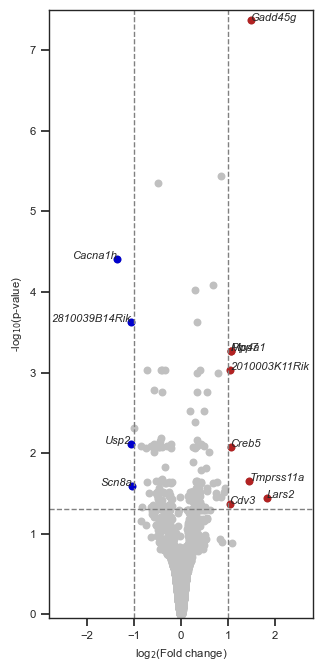

In [15]:
matplotlib.rcParams.update({'font.size': 8.2, 'axes.titlesize': 8.2, 'axes.labelsize': 8.2,
                           'xtick.labelsize': 8.2, 'ytick.labelsize': 8.2, 'legend.fontsize': 8.2,
                            'text.usetex': False, 'svg.fonttype': 'none',
                           'xtick.direction': 'out', 'ytick.direction': 'out',
                            'xtick.bottom': True, 'ytick.left': True, 'axes.linewidth':1})


matplotlib.rcParams.update({'ytick.left': True})
padj_thr = 0.05
lfc_thr = 1

type_list = ["vgic", "lgic", "other_ic", "transporter", "gpcr"]
anno_list = ["Star", "Agtr1a"]
anno_list_3 = [ "Cyp11b2", "Agtr1b", "Agtr2"]
anno_list_2 = ["Cacna1c", "Cacna1d", "Cacna1g"]



#fig, ax = plt.subplots(figsize=(3.4,4))
fig, ax = plt.subplots(figsize=(3.4,7.9))



data_all = data.dropna(subset=["log2FoldChange", "padj", "GENENAME"])
data_all_up = data_all[(data_all["log2FoldChange"] > lfc_thr) & (data_all["padj"] < 0.05)]
data_all_down = data_all[(data_all["log2FoldChange"] < -lfc_thr) & (data_all["padj"] < 0.05)]

data_all_up_in_list = data_all_up[data_all_up["Type"].isin(type_list)]
data_all_down_in_list = data_all_down[data_all_down["Type"].isin(type_list)]



ax.scatter(x=data_all["log2FoldChange"],\
            y=data_all["-log10_padj"], color ="silver", s=22, label='not significant')

ax.scatter(x=data_all_up["log2FoldChange"],\
            y=data_all_up["-log10_padj"], color="firebrick", s=22, label='significantly upregulated' )

ax.scatter(x=data_all_down["log2FoldChange"],\
            y=data_all_down["-log10_padj"], color="mediumblue", s=22, label='significantly downregulated' )




ax.set_ylabel("-log10_padj")
ax.set_xlabel("log2FoldChange")





for i in data_all_down["GENENAME"].values:
    gene = data_all_down[data_all_down["GENENAME"] == i]
    y = gene["-log10_padj"].values[0]
    x = gene["log2FoldChange"].values[0]
    
    ax.annotate(gene["GENENAME"].values[0], xy=(x, y), xytext=(x, y), fontsize = 8, 
                    style = "italic", ha="right")

    
for i in data_all_up["GENENAME"].values:
    gene = data_all_up[data_all_up["GENENAME"] == i]
    y = gene["-log10_padj"].values[0]
    x = gene["log2FoldChange"].values[0]
        
    ax.annotate(gene["GENENAME"].values[0], xy=(x, y), xytext=(x, y), fontsize = 8, 
                    style = "italic",)
    

  
    
    

### plot data outside range    ####################    
plot_limits=2.8

data_outside_lim_up = data_all[data_all["log2FoldChange"] >= plot_limits]      
data_outside_lim_down = data_all[data_all["log2FoldChange"] <= -plot_limits]      
        
#ax.scatter(x=[2.96,2.96],\
#            y=data_outside_lim_up["-log10_padj"], color ="grey", s=10, label='LFC > 3', marker=">", facecolor='none')    
    
#ax.scatter(x=[-2.96],\
#            y=data_outside_lim_down["-log10_padj"], color ="grey", s=10, label='LFC < -3', marker="<", facecolor='none')   

###################################################

ax.set_ylim(-0.05, 7.5)
ax.set_xlim(-plot_limits, plot_limits)

ax.set_ylabel("-log${_{10}}$(p-value)")   
ax.set_xlabel("log${_{2}}$(Fold change)")       

#ax.legend()

ax.axhline(-np.log10(padj_thr),0,10, ls="--", color="grey", lw=1)
ax.axvline(-1,0,10, ls="--", color="grey",lw=1)
ax.axvline(1,0,10, ls="--", color="grey",lw=1)

fig.savefig("RNASeq_volcano_shrink.png", dpi=1200)
fig.savefig("RNASeq_volcano_shrink.svg", dpi=1200)

In [18]:
data_DE_all_sortL2FC = pd.concat([data_all_up.sort_values(by=["log2FoldChange"], ascending=False),
           data_all_down.sort_values(by=["log2FoldChange"], ascending=False)])

data_DE_all_sortL2FC

,GENEID,baseMean,log2FoldChange,lfcSE,pvalue,padj,GENENAME,SYMBOL,ENTREZID,Type,Family id,Family name,Target id,Target name,Subunits,Target systematic name,Target abbreviated name,synonyms,MGI id,MGI symbol,MGI name,Mouse Ensembl Gene,padj_rounded,GENENAME_padj,-log10_padj
9952,ENSMUSG00000035202,4680.061440,1.820094,0.697889,3.046884e-04,3.647998e-02,Lars2,Lars2,102436.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.6e-02,Lars2\np=3.6e-02,1.437945
3105,ENSMUSG00000021453,242.977276,1.492890,0.228217,3.024359e-12,4.272815e-08,Gadd45g,Gadd45g,23882.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.3e-08,Gadd45g\np=4.3e-08,7.369286
18880,ENSMUSG00000072845,23.235980,1.455469,0.478889,9.061068e-05,2.209341e-02,Tmprss11a,Tmprss11a,194597.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2e-02,Tmprss11a\np=2.2e-02,1.655737
15266,ENSMUSG00000053007,4068.907721,1.068352,0.314270,2.501755e-05,8.368726e-03,Creb5,Creb5,231991.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.4e-03,Creb5\np=8.4e-03,2.077341
16124,ENSMUSG00000057440,837.041742,1.061426,0.238488,3.823155e-07,5.401354e-04,Mpp7,Mpp7,75739.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.4e-04,Mpp7\np=5.4e-04,3.267497
5334,ENSMUSG00000026064,241.629377,1.055277,0.236007,3.465161e-07,5.401354e-04,Ptp4a1,Ptp4a1,19243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.4e-04,Ptp4a1\np=5.4e-04,3.267497
12417,ENSMUSG00000042041,148.059701,1.044430,0.247909,1.067232e-06,9.423659e-04,2010003K11Rik,2010003K11Rik,69861.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.4e-04,2010003K11Rik\np=9.4e-04,3.025780
9139,ENSMUSG00000032803,7885.570112,1.035186,0.404309,3.896123e-04,4.234187e-02,Cdv3,Cdv3,321022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.2e-02,Cdv3\np=4.2e-02,1.373230
4030,ENSMUSG00000023033,48.204375,-1.032317,0.367088,1.401763e-04,2.571963e-02,Scn8a,Scn8a,20273.0,vgic,82.0,Voltage-gated sodium channels (Na<sub>V</sub>),583.0,Na<sub>v</sub>1.6,NaN,NaN,NaN,CerIII|NaCh6|PN4|MED|peripheral nerve protein ...,MGI:103169,Scn8a,"sodium channel, voltage-gated, type VIII, alpha",ENSMUSG00000023033,2.6e-02,Scn8a\np=2.6e-02,1.589735
27433,ENSMUSG00000099034,36.526190,-1.058356,0.225508,1.218341e-07,2.361395e-04,2810039B14Rik,2810039B14Rik,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4e-04,2810039B14Rik\np=2.4e-04,3.626831


In [19]:
data_DE_all_sortL2FC.sort_values(by=["log2FoldChange"], ascending=True)[["GENENAME", 
                                                                         "log2FoldChange", 
                                                                         "padj_rounded"]]\
.round(3)\
.to_excel("data_l2fc_p_DEG_230413.xlsx")

In [20]:
genes_of_interest = ["Cacna1h", 
                     "Cacna1c",
                     "Cacna1d",
                     "Star", 
                     "Agtr1a", 
                     "Agtr1b", 
                     "Agtr2", 
                     "Cyp11b2",
                     "Kcnk3",#TASK channels
                     "Kcnk5",
                     "Kcnk9",
                     "Kcnk15",
                     "Kcnma1",#BK channel
                     "Kcnn1", #SK channels
                     "Kcnn2",
                     "Kcnn3",
                     "Kcnn4",
                     "Kcnj3", #GIRK channels
                     "Kcnj6",
                     "Kcnj9"
                    ]

In [21]:
data_all_goi = data_all[data_all["GENENAME"].isin(genes_of_interest)]
data_all_goi.sort_values(by=["log2FoldChange"], ascending=True)

,GENEID,baseMean,log2FoldChange,lfcSE,pvalue,padj,GENENAME,SYMBOL,ENTREZID,Type,Family id,Family name,Target id,Target name,Subunits,Target systematic name,Target abbreviated name,synonyms,MGI id,MGI symbol,MGI name,Mouse Ensembl Gene,padj_rounded,GENENAME_padj,-log10_padj
4303,ENSMUSG00000024112,2327.226910,-1.348250,0.262770,1.090519e-08,0.000039,Cacna1h,Cacna1h,58226.0,vgic,80.0,Voltage-gated calcium channels (Ca<sub>V</sub>),536.0,Ca<sub>v</sub>3.2,NaN,NaN,NaN,a1H|alpha-1H|calcium channel,MGI:1928842,Cacna1h,"calcium channel, voltage-dependent, T type, al...",ENSMUSG00000024112,3.9e-05,Cacna1h\np=3.9e-05,4.414346
15647,ENSMUSG00000054988,405.449547,-0.021236,0.061451,4.456527e-01,0.866050,Agtr1b,Agtr1b,11608.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.7e-01,Agtr1b\np=8.7e-01,0.062457
499,ENSMUSG00000002908,73.401200,-0.014620,0.066091,2.842965e-01,0.782611,Kcnn1,Kcnn1,84036.0,vgic,69.0,Calcium- and sodium-activated potassium channe...,381.0,K<sub>Ca</sub>2.1,NaN,NaN,NaN,SK1|SKCa1|small conductance calcium-activated ...,MGI:1933993,Kcnn1,potassium intermediate/small conductance calci...,ENSMUSG00000002908,7.8e-01,Kcnn1\np=7.8e-01,0.106454
4096,ENSMUSG00000023243,273.950895,-0.013202,0.066831,6.920826e-02,0.483493,Kcnk5,Kcnk5,16529.0,vgic,79.0,Two-pore domain potassium channels (K<sub>2P<...,517.0,K<sub>2P</sub>5.1,NaN,NaN,TASK2,TASK-2|potassium channel subfamily K member 5|...,MGI:1336175,Kcnk5,"potassium channel, subfamily K, member 5",ENSMUSG00000023243,4.8e-01,Kcnk5\np=4.8e-01,0.315610
3776,ENSMUSG00000022589,6756.439472,-0.009134,0.063916,5.393133e-01,0.904201,Cyp11b2,Cyp11b2,13072.0,enzyme,266.0,"CYP11, CYP17, CYP19, CYP20 and CYP21 families",1360.0,CYP11B2,NaN,NaN,Aldosterone synthase,ALDOS|aldosterone-synthesizing enzyme|cytochro...,MGI:88584,Cyp11b2,"cytochrome P450, family 11, subfamily b, polyp...",ENSMUSG00000022589,9.0e-01,Cyp11b2\np=9.0e-01,0.043735
10444,ENSMUSG00000036760,6020.801974,-0.006955,0.065211,4.576163e-01,0.869831,Kcnk9,Kcnk9,223604.0,vgic,79.0,Two-pore domain potassium channels (K<sub>2P<...,520.0,K<sub>2P</sub>9.1,NaN,NaN,TASK3,TASK-3|acid-sensitive potassium channel protei...,MGI:3521816,Kcnk9,"potassium channel, subfamily K, member 9",ENSMUSG00000036760,8.7e-01,Kcnk9\np=8.7e-01,0.060565
18026,ENSMUSG00000068122,543.322560,-0.006643,0.064549,5.777480e-01,0.916383,Agtr2,Agtr2,11609.0,gpcr,6.0,Angiotensin receptors,35.0,AT<sub>2</sub> receptor,NaN,NaN,NaN,MRX88|angiotensin receptor 2|angiotensin II ty...,MGI:87966,Agtr2,"angiotensin II receptor, type 2",ENSMUSG00000068122,9.2e-01,Agtr2\np=9.2e-01,0.037923
17342,ENSMUSG00000063142,2307.017567,-0.005564,0.062379,7.697755e-01,0.967658,Kcnma1,Kcnma1,16531.0,vgic,69.0,Calcium- and sodium-activated potassium channe...,380.0,K<sub>Ca</sub>1.1,NaN,NaN,NaN,BK channel|BK channel alpha subunit|calcium-ac...,MGI:99923,Kcnma1,potassium large conductance calcium-activated ...,ENSMUSG00000063142,9.7e-01,Kcnma1\np=9.7e-01,0.014278
15521,ENSMUSG00000054342,19.764408,0.000481,0.064213,9.672142e-01,0.997111,Kcnn4,Kcnn4,16534.0,vgic,69.0,Calcium- and sodium-activated potassium channe...,384.0,K<sub>Ca</sub>3.1,NaN,NaN,NaN,Gardos channel|IK<sub>Ca</sub>1|Ik1|KCa4|inter...,MGI:1277957,Kcnn4,potassium intermediate/small conductance calci...,ENSMUSG00000054342,1.0e+00,Kcnn4\np=1.0e+00,0.001257
137,ENSMUSG00000000794,83.814982,0.003009,0.063510,8.405325e-01,0.980841,Kcnn3,Kcnn3,140493.0,vgic,69.0,Calcium- and sodium-activated potassium channe...,383.0,K<sub>Ca</sub>2.3,NaN,NaN,NaN,SK3|SKCa3|small conductance calcium-activated ...,MGI:2153183,Kcnn3,potassium intermediate/small conductance calci...,ENSMUSG00000000794,9.8e-01,Kcnn3\np=9.8e-01,0.008401


In [23]:
data_all_goi[["GENENAME", "log2FoldChange", "padj_rounded"]].round(3).to_excel("data_l2fc_p_goi_230413.xlsx")